In [136]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l2
import os
from os import listdir
import gdown
from zipfile import ZipFile
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer

In [183]:
orignal_svm = keras.models.load_model('plant_pepper_svm.h5')
combined_svm = keras.models.load_model('plant_strawberry_combined_WGAN_svm.h5')
standAlone_svm = keras.models.load_model('plant_strawberry_standAlone_WGAN_svm.h5')



In [184]:
def evaluate_model_svm(svm_model, test_set, label_set):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix

    y_prob = svm_model.predict(test_set)
    y_pred = np.where(y_prob[:len(test_set)] >= 0.5, 1, 0)
    
    # y_pred = model.predict(x_test)
    # print(y_pred)
    # # mse = mean_squared_error(y_test, y_pred)
    # # print(mse)
    accuracy = accuracy_score(label_set, y_pred)
    precision = precision_score(label_set, y_pred)
    recall = recall_score(label_set, y_pred)
    f1 = f1_score(label_set, y_pred)
    conf_matrix = confusion_matrix(label_set, y_pred)
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Set the font scale
    sns.set(font_scale=2.0)

    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

    # Create the heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax)

    # Set the title and axis labels
    ax.set_title('strawberry', fontsize=15)
    ax.set_xlabel('Predicted Labels', fontsize=15)
    ax.set_ylabel('True Labels', fontsize=15)

    # Save the figure and show the plot
    plt.savefig('strawberry WGAN.png', dpi=300, bbox_inches='tight')
    plt.show()
#     print(conf_matrix)

#     print("Accuracy:", accuracy * 100)
#     print("Precision:", precision * 100)
#     print("Recall:", recall * 100)
#     print("F1-score:", f1 * 100)
    return accuracy, precision, recall, f1, conf_matrix

In [185]:
from tensorflow.keras.utils import img_to_array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            img_gan = cv2.resize(image, (32,32))
            return img_to_array(img_gan)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [186]:
def extract_plant_imgs(directory_root):
    image_list, label_list = [], []
    try:
        print("[INFO] Loading images ...")
        root_dir = listdir(directory_root)
        #print(root_dir)
        for plant_folder in root_dir :
            # remove .DS_Store from list
            if plant_folder == ".DS_Store" :
                root_dir.remove(directory)


        for plant_folder in root_dir :
    #         print("on plant folder")
            plant_image_list = listdir(f"{directory_root}/{plant_folder}")



            for single_image in plant_image_list :

    #             print("in plant folder")
                if single_image == ".DS_Store" :
                    plant_image_list.remove(single_image)

            for image in plant_image_list[:1000]:
    #             print("getting img path")
                image_directory = f"{directory_root}/{plant_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
    #                 print("checking if img correct format")
                    gan_img = convert_image_to_array(image_directory)
                    image_list.append(gan_img)
                    label_list.append(plant_folder)

        print("[INFO] Image loading completed")
        return image_list, label_list
    except Exception as e:
        print(f"Error : {e}")

In [187]:
def pretty_print(accuracy, precision, recall, f1, conf, model_type ):
    print("Evaluation for " + model_type)
    print("Accuracy:", accuracy * 100)
    print("Precision:", precision * 100)
    print("Recall:", recall * 100)
    print("F1-score:", f1 * 100)
    print("True positives:", conf[0][0])
    print("False positives:", conf[0][1])
    print("False Negatives:", conf[1][0])
    print("True negatives:", conf[1][1])

In [188]:
orignal_data = 'Orignal_strawberry'
orignal_image_list , orignal_label_list = extract_plant_imgs(orignal_data)

[INFO] Loading images ...
[INFO] Image loading completed


In [189]:
new_image_list = np.array(orignal_image_list, dtype = np.float16) / 255.0
print(new_image_list.shape)

(2000, 32, 32, 3)


In [190]:
label_gen = LabelBinarizer()
image_labels = label_gen.fit_transform(orignal_label_list)
pickle.dump(label_gen,open('label_transform.pkl', 'wb'))
n_classes = len(label_gen.classes_)
print(n_classes)
print(image_labels)

2
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [191]:
from sklearn.model_selection import train_test_split
print("making the training and testing split with 30% of the dataset as testing set")
x_train, x_test, y_train, y_test = train_test_split(new_image_list, image_labels, test_size=0.3, shuffle=True,random_state = 42) 
print(x_train.shape)
print(x_test.shape)

making the training and testing split with 30% of the dataset as testing set
(1400, 32, 32, 3)
(600, 32, 32, 3)


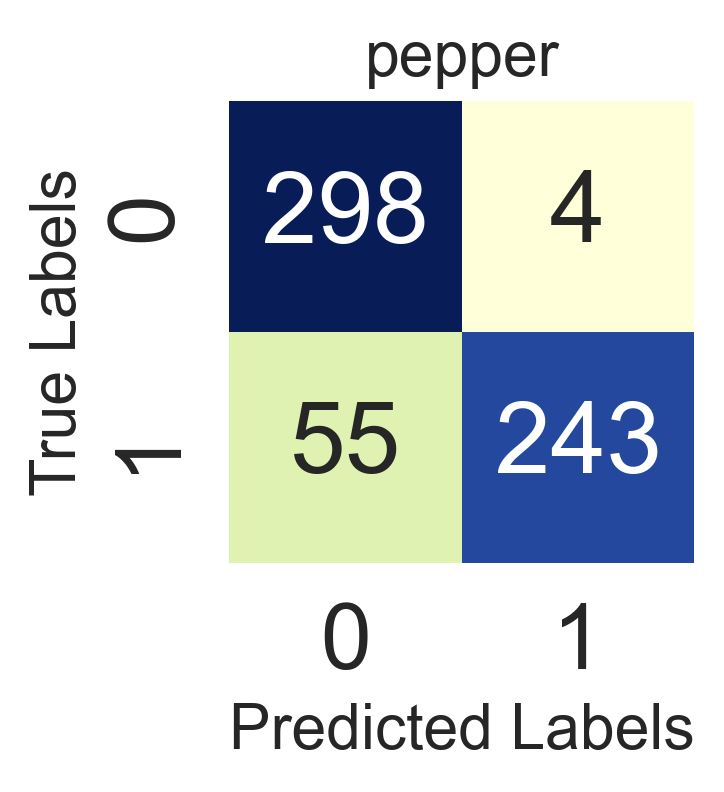

In [146]:
orig_acc, orig_prei, orig_recall, orig_f1, orig_conf_mat = evaluate_model_svm(orignal_svm, 
   x_test, y_test)

In [147]:
type_model = "SVM using orignal dataset"
pretty_print(orig_acc, orig_prei, orig_recall, orig_f1, orig_conf_mat, type_model)

Evaluation for SVM using orignal dataset
Accuracy: 90.16666666666666
Precision: 98.38056680161942
Recall: 81.54362416107382
F1-score: 89.17431192660551
True positives: 298
False positives: 4
False Negatives: 55
True negatives: 243


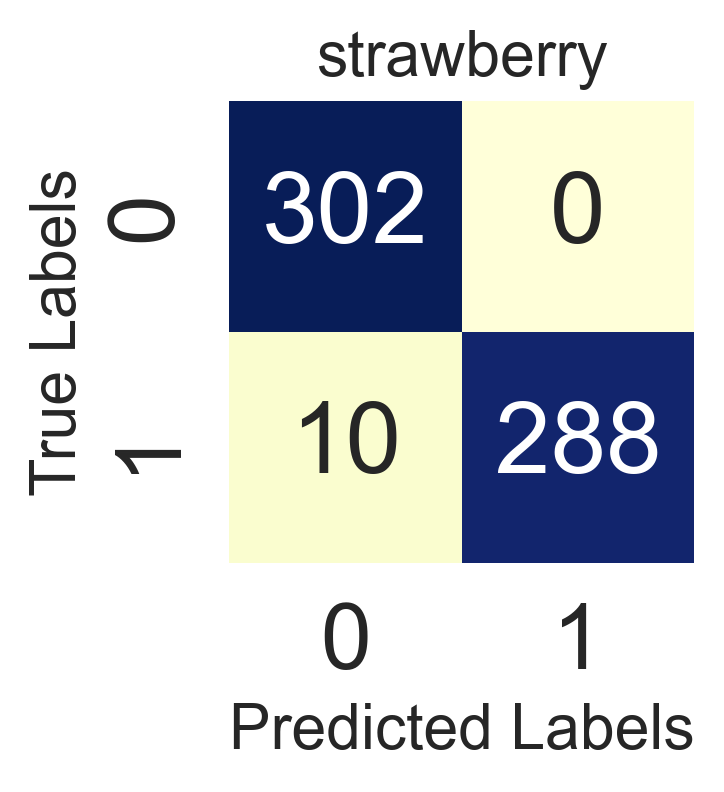

In [134]:
comb_acc, comb_prei, comb_recall, comb_f1, comb_conf = evaluate_model_svm(combined_svm, x_test, y_test)

In [135]:
type_model2 = "SVM using combined dataset"
pretty_print(comb_acc, comb_prei, comb_recall, comb_f1, comb_conf, type_model2)

Evaluation for SVM using combined dataset
Accuracy: 98.33333333333333
Precision: 100.0
Recall: 96.64429530201343
F1-score: 98.29351535836179
True positives: 302
False positives: 0
False Negatives: 10
True negatives: 288


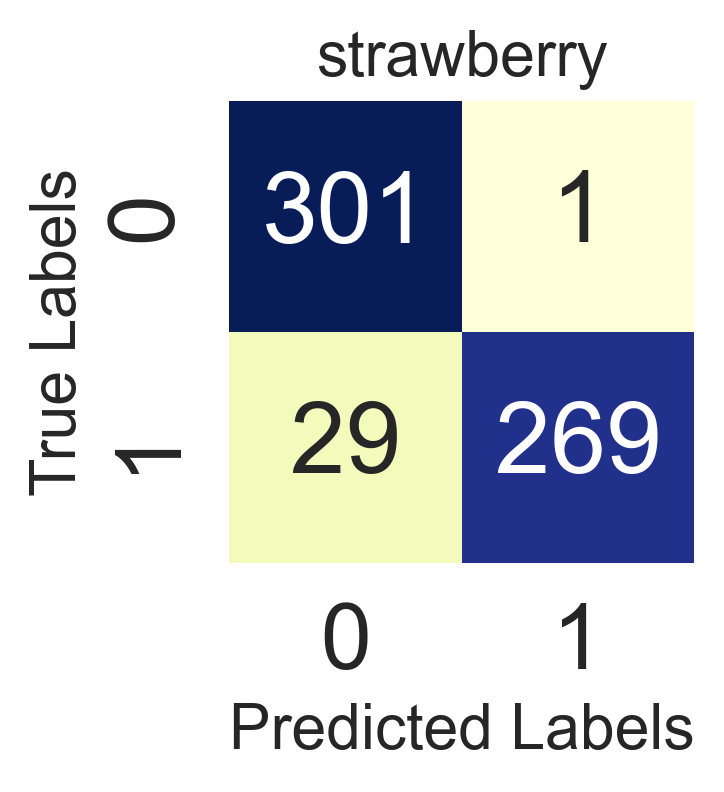

In [192]:
gen_acc, gen_prei, gen_recall, gen_f1, gen_conf = evaluate_model_svm(standAlone_svm, 
   x_test, y_test)

In [193]:
type_model3 = "SVM using only the generated dataset"
pretty_print(gen_acc, gen_prei, gen_recall, gen_f1, gen_conf, type_model3)

Evaluation for SVM using only the generated dataset
Accuracy: 95.0
Precision: 99.62962962962963
Recall: 90.26845637583892
F1-score: 94.71830985915493
True positives: 301
False positives: 1
False Negatives: 29
True negatives: 269
